# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

Einlesen der Trainings- und Testdaten.

In [4]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [5]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [6]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [7]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [8]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [9]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [10]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [11]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add new feature manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(handle_unknown='ignore'), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

### Undersampling

In [12]:
# sort data according to repair status
df_train_1 = df_train[df_train["t_needs_rep"] == 1] 
df_train_0 = df_train[df_train["t_needs_rep"] == 0]

num_r = len(df_train_1) # number of needs-repair pumps
print(f"{num_r} pumps need repairs, therefore we need the same amount of pumps that don't need repairs")

df_sample=df_train_0.sample(num_r) # get same amount of other pumps
df_train_r = pd.concat([df_train_1, df_sample]) # combine data samples
df_train_r = df_train_r.sample(frac=1) # shuffle dataset
print(df_train_r["t_needs_rep"].value_counts())


3356 pumps need repairs, therefore we need the same amount of pumps that don't need repairs
1    3356
0    3356
Name: t_needs_rep, dtype: int64


In [13]:
y_train_r = df_train['t_needs_rep']
X_train_r = col_trans.fit_transform(X=df_train, y=y_train_r)

### Preparation Test Data

In [14]:
df_test = df_pump_test.copy()

df_test["t_functional"] = df_test["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_test["t_needs_rep"] = df_test["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

df_test = df_test.drop(df_test[df_test.longitude == 0].index)

df_test["amount_per_capita"] = df_test.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

df_test["district_code"] = df_test["district_code"].astype("category")
df_test["region_code"] = df_test["region_code"].astype("category")

y_test = df_test.loc[:,'status_group']
y_test = le.transform(y_test)

y_test_f = df_test["t_functional"]
y_test_r = df_test["t_needs_rep"]

X_test = col_trans.transform(X=df_test)

## Modeling

**Prognosemodell für die Brunnen die repariert werden müssen**

- normal models
- pca
- balancing
- experiment with construction year

### a. Model Selection

In [15]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV", "ACC CV"])

#### LogisticRegression

https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

lr_cf = LogisticRegression(max_iter=1000, random_state=42)
lr_cf.fit(X_train_r, y_train_r)
y_pred = lr_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [ ]:
from sklearn.svm import SVC

svm_cf = SVC(probability=True, random_state=42)
svm_cf.fit(X_train_r, y_train_r)
y_pred = svm_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv, acc_cv]

#### KNN

In [149]:
from sklearn.neighbors import KNeighborsClassifier

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train_r, pd.DataFrame(y_train_r))
y_pred = knn_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=knn_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv, acc_cv]

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

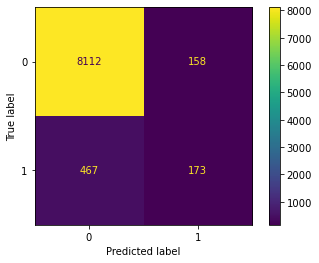

In [186]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = knn_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=knn_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_cf.classes_)
disp.plot()
plt.show()

#### Decision Tree

In [1]:
from sklearn.tree import DecisionTreeClassifier

dt_cf = DecisionTreeClassifier(random_state=42)
dt_cf.fit(X_train_r, y_train_r)
y_pred = dt_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=dt_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv, acc_cv]

NameError: name 'X_train_r' is not defined

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

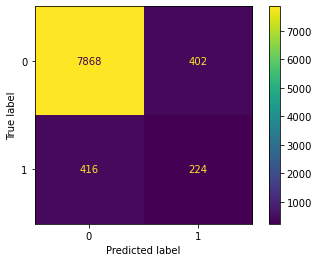

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = dt_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=dt_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_cf.classes_)
disp.plot()
plt.show()

#### Random Forest

In [134]:
from sklearn.ensemble import RandomForestClassifier

rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_r, y_train_r)
y_pred = rf_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=rf_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [rf_cf, auc_train, auc_cv, acc_cv]

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

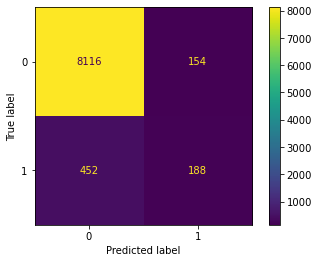

In [189]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=rf_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cf.classes_)
disp.plot()
plt.show()

#### XGBoost

In [27]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier(use_label_encoder=False)
xgb_cf.fit(X_train_r, y_train_r)
y_pred = xgb_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)
cv_res = cross_validate(estimator=xgb_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv, acc_cv]

[02:50:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: multi_class must be in ('ovo', 'ovr')

#### Model Score Comparison

In [136]:
df_results.to_csv("pm2_sel_results.csv")
df_results

,Model,AUC Train,AUC CV,ACC CV
0,"LogisticRegression(max_iter=1000, random_state...",0.929868,0.924662,0.839244
1,"SVC(probability=True, random_state=42)",0.942028,0.920962,0.838054
2,KNeighborsClassifier(),0.939398,0.854981,0.784269
3,DecisionTreeClassifier(random_state=42),1.000000,0.786349,0.786352
4,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.901950,0.821217
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.989206,0.920916,0.826580


### b. Hyperparameter Tuning

Gewählte Modelle:
- LogisticRegression
- SupportVectorMachine
- XGBoost
--> Bester CV-Score, trotzdem noch Overfitting, viele Hyperparameter zum Anpassen

In [96]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### Logistic Regression

In [102]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'penalty' : ['l1', 'l2', 'none'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [1000, 2000]
}]

lr_cf = LogisticRegression(random_state=42)
gs = GridSearchCV(lr_cf, param_grid=param_grid, scoring="roc_auc", cv=3, verbose = 1, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 3 folds for each of 150 candidates, totalling 450 fits


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hammerer/opt/anaconda3/lib/p

{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

In [103]:
lr_cf = gs.best_estimator_

lr_cf.fit(X_train_r, y_train_r)
y_pred = lr_cf.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

In [106]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}]

svm_cf = SVC(probability=True, random_state=42, decision_function_shape="ovr")
gs = GridSearchCV(svm_cf, param_grid=param_grid, scoring="roc_auc", cv=3, verbose = 2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  22.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  31.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  31.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  32.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  22.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  22.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  26.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  26.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  26.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  31.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  33.0s
[CV] END .....................C=0.1, gamma=0.001

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [108]:
svm_cf = gs.best_estimator_

svm_cf.fit(X_train_r, y_train_r)
y_pred = svm_cf.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring, n_jobs=-1)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv, acc_cv]

#### XGBoost

In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "n_estimators":[100, 250, 500],
    "max_depth": [5, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1]
}]

xgb_cf = XGBClassifier(use_label_encoder=False)
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc", cv=3, verbose = 2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[23:45:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [111]:
xgb_cf = gs.best_estimator_

xgb_cf.fit(X_train_r, y_train_r)
y_pred = xgb_cf.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=xgb_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv, acc_cv]

[00:04:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

#### Model Score Comparison

In [112]:
df_tuned.to_csv("pm2_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV
0,"LogisticRegression(C=1, penalty='l1', solver='...",0.929642,0.925050
1,"LogisticRegression(C=1, penalty='l1', random_s...",0.929642,0.925051
2,"LogisticRegression(C=1, max_iter=1000, penalty...",0.929642,0.925046
3,"SVC(C=10, gamma=0.01, probability=True, random...",0.935907,0.924069
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.954390,0.931043


## Evaluation

- Test Set
- ROC Visualization

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

In [197]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

p_lr = make_pipeline(col_trans, lr_cf)
p_lr.fit(df_train, y_train_r)
y_pred = p_lr.decision_function(df_test)
lr_disp = RocCurveDisplay.from_predictions(y_test_r, y_pred)

p_svm = make_pipeline(col_trans, svm_cf)
p_svm.fit(df_train, y_train_r)
y_pred = p_svm.decision_function(df_test)
svm_disp = RocCurveDisplay.from_predictions(y_test_r, y_pred, ax=lr_disp.ax_)

#p_xgb = make_pipeline(col_trans, xgb_cf)
#p_xgb.fit(df_train, y_train_r)
#y_pred = p_xgb.decision_function(df_test)
#xgb_disp = RocCurveDisplay.from_predictions(y_test_r, y_pred, ax=lr_disp.ax_)

lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

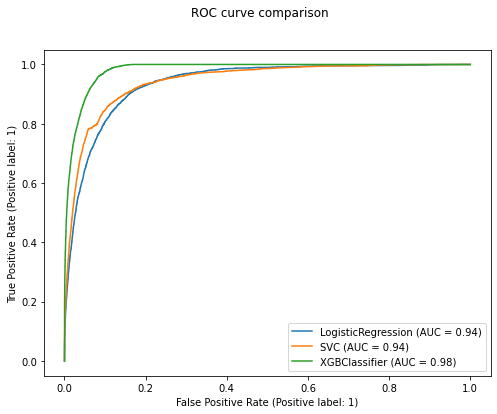

In [196]:
lr_disp = RocCurveDisplay.from_estimator(lr_cf, X_train_r, y_train_r)
svm_disp = RocCurveDisplay.from_estimator(svm_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

AttributeError: 'SVC' object has no attribute 'support_vectors_'

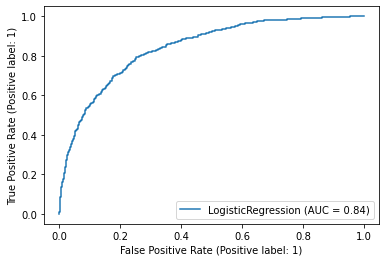

In [21]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

lr_disp = RocCurveDisplay.from_estimator(lr_cf, X_test, y_test_r)
#svm_disp = RocCurveDisplay.from_estimator(svm_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()